# Rotten Tomatoes Sentiment Prediction
This notebook describes the models that Anne LoVerso and Casey Alvarado used to predict the sentiment for movie reviews. We downloaded data from the Kaggle Movie Review Sentiment, [Kaggle Movie Review Sentiment](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews), and used the provided reviews and sentiment to to predict the sentiment for each phrase.  The Kaggle data gives us a series of sentences and their corresponding sentiment value on the following scale:
- 0: very negative
- 1: somewhat negative
- 2: neutral
- 3: somewhat positive
- 4: very positive

The sentences are also broken down into chunks of phrases that make up each sentence, and the sentiment of each phrase that makes up a sentence.

The following describes the contents of this notebook:

## Exploration
- Mean of Sentence Components
    - How does the sentiments of individual phrases compare to the sentence they came from?
- Using Pattern to analyze sentiment, subjectivity, and modality
- Exploring the most common words in positive and negative reviews

## Classification Models
- Naive Bayes Classifier
    - implemented by hand
    - using sklearn MultinomialNB
    - using NLTK
- sklearn Pipeline with a variety of estimators
- Using Logistic Regression

## Neural Network
- Creating an MLP network using [Lasagne](https://github.com/Lasagne/Lasagne)

# Intro Code
This code that creates the data and testdata pandas dataframe, and a function that makes a Kaggle submission file, both get used consistently throughout the file, so both of these should be compiled at the beginning.

In [52]:
import numpy as np 
import pandas 
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import time
import theano
import theano.tensor as T
import lasagne
import pickle
import string
import wordcloud
from pattern.en import *
from collections import Counter

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import LabelShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer as TFIV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

import sys 
sys.path.insert(0, 'ThinkStats2')
import thinkstats2

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

data = pandas.read_csv('train.tsv', sep = '\t') 
testdata = pandas.read_csv('test.tsv', sep = '\t') 

In [11]:
def make_submission(predictions, filename):
    # Create a new dataframe with only the columns Kaggle wants from the dataset.
    submission = pandas.DataFrame({
            "PhraseId": testdata["PhraseId"],
            "Sentiment": predictions
        })
    submission.to_csv(filename, index=False)

# Exploration

## Mean of Sentence Components
The movie reviews contained both the whole sentences and the segements of these sentences that made up these sentences. As well as the sentiment value for all of this phrases. First, we were curious to find out of there was a correlation between the sentiment value of the sentence as a whole and the averaged sentiment of the sentence segments. How close are the average sentement value of the segments in comparison to the sentiment of the sentence as a whole?
We averaged all the sentiment of the segments that corresponded to each sentence, as indicated by the sentence id. Then compared that number to the sentiment of the sentence as a whole. 

In [3]:
# acquire all of the sentence ids, just once into a list. 
#This will help us iterate through the phrases to find all of the phrases that correspond to each sentence id. 

sentenceIds = list(set(data.SentenceId))

In [4]:
sentenceSentiments = []
phraseMeans = []

# The following loop will do the following for each sentence id: 
#find every segment that corresponds to the sentence id,take the mean sentiments of all of the phrases, 
# and append to phraseMeans
#find the sentence that belongs to the sentence id, find sentiment, and append to sentenceSentiments

for i in sentenceIds: 
    phraseSents = data.Sentiment[data.PhraseId[data.SentenceId == i]]
    mean = phraseSents[2:len(phraseSents)].mean(); 
    phraseMeans.append(mean)
    sentenceSentiments.append(data.Sentiment[data.SentenceId == i].iloc[0])

/home/anne/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


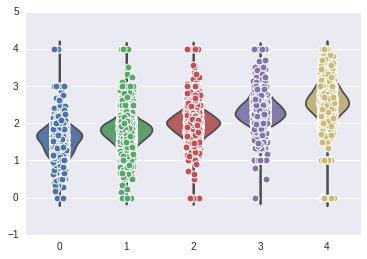

In [5]:
# making seaborn plot
ax = sns.stripplot(x=sentenceSentiments, y=phraseMeans, jitter = True, order = [0, 1, 2, 3, 4])
sns.violinplot(x=sentenceSentiments, y=phraseMeans, order = [0, 1, 2, 3, 4])

The graph above shows us that there is a positive correlation between the sentiment of the sentence and the average mean of the segments. The vertical lines seem to be increasing, this is because sentiment is also increasing so the mean of phrases with higher sentiments would also increase. This scatter plot also shows that the mean is closests to 2 when sentiment is around 2. The violin plot helps show the concentation of the mean sentiment values. It looks like these concentrations are increasing linearly. More importantly, notice that the concentrations for each sentiment value is not around the sentence sentiment value. For example, for sentence sentiment = 1, the concentration of the average phrase sentiment looks to be around 2. 
We can use thinkstats2's cross correlation function to calculate how dependent these two data sets are on each other and therefore, tell us the magnitude of the correlation.  

There are two main correlations that we can take that will give us an idea of how these two datasets are related: 
1. The Pearson Correlation transforms each value into a standard score. Then calculates how far away from the mean is each standard score. This correlation ranks them according to how far they are from the mean.  This value is usually between -1 and +1. If this number is positive, then we can say that when one dataset is high, then the other data set will also be high. If the correlation value is -1 or 1, then the two series are perfectly correlated, which means if we know one then we know the other. 
2. The Spearman Correlation ranks each value and returns the index. This correlation type is better for nonlinear values and outliers. 

In [6]:
#converting these into pandas series to work with the correlation function. 
#Cleaning the phraseMeans series dataframe because taking the mean produced some not a number entries.
sentenceSentiments = pandas.Series(sentenceSentiments)
phraseMeans = pandas.Series(phraseMeans).fillna(2.0)

In [7]:
#calling the correlation functions
pearson_l_m = thinkstats2.Corr(sentenceSentiments, phraseMeans)
spearman_l_m = thinkstats2.SpearmanCorr(sentenceSentiments, phraseMeans)
print pearson_l_m
print spearman_l_m

0.633769287721
0.683130561304


The Pearson correlation and the Spearman correlation values are close in magnitude and positive. This means that there is a strong correlation between the sentiment value and the mean of the segment phrases sentiment value. Therefore, if we know one, we can make an educated guess about the other that will likely be close enough. The mean sentiment per phrase to be super far off from the sentiment of the sentence.

## Using Pattern
We installed the Pattern package and used its sentiment analysis tool to see what Pattern thought the sentiment values for each phrase might be.

This function called `get_map_pattern` gets the pattern sentiment for a given phrase and remaps it to the same interval as the original data.  Pattern sentiment returns a value from -1 to 1, and we want our sentiment to be an integer from 0 to 4.  We use `np.digitize` to sort the score into a bin.  The arrangement of the bins is currently evenly distributed, but depending on how Pattern sentiment works, it might make sense to shift the bins around so they better match the original data spread.

In [9]:
def get_map_pattern(phrase):
    pos_neg, obj_subj = sentiment(phrase) #pos_neg on scale -1 to 1
    bins = np.array([-1.0, -0.6, -0.2, 0.2, 0.6, 1.01])
    binplace = np.digitize(pos_neg, bins)-1
    return binplace

data['PatternSentiment'] = data["Phrase"].apply(lambda x: get_map_pattern(x))

In [12]:
predictions = testdata["Phrase"].apply(lambda x: get_map_pattern(x))
make_submission(predictions, "pattern1.csv")

For fun, we used pattern to analyze the sentiment of our test data, doing nothing but applying our get_map_pattern function to our new phrases.  This scored **0.53697** on Kaggle, which is better than the neutral benchmark but not good by any means.

We can take a look at where Pattern scored poorly by graphing what pattern predicted for a given phrase compared to what its actual sentiment is, and seeing how much they do or don't overlap.

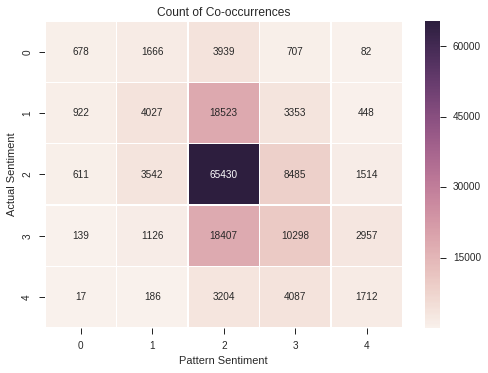

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline
from scipy.stats import kendalltau

sns.set(style="ticks")

rs = np.random.RandomState(11)
x = data.Sentiment
y = data.PatternSentiment

#sns.jointplot(x, y, tkind="hex")
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

zvals = np.ones([5,5])
zvalslog = np.ones([5,5])

for i in range(5):
    for j in range(5):
        zvalslog[i][j] = np.log(len(data.Sentiment[data.Sentiment==i][data.PatternSentiment==j]))
        zvals[i][j] = len(data.Sentiment[data.Sentiment==i][data.PatternSentiment==j])

sns.heatmap(zvals, annot=True, fmt="g", linewidths=.5)
sns.axlabel("Pattern Sentiment", "Actual Sentiment")
sns.plt.title("Count of Co-occurrences")

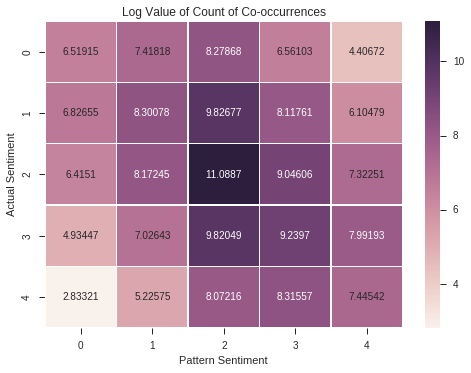

In [14]:
sns.heatmap(zvalslog, annot=True, fmt="g", linewidths=.5)
sns.axlabel("Pattern Sentiment", "Actual Sentiment")
sns.plt.title("Log Value of Count of Co-occurrences")

### Graph Analysis
The first plot shows the raw counts of how many phrases fall into each sentiment box for each system.  In an ideal world, this plot would have a perfect negative diagonal slope, as everything Pattern predicted would be the actual score.  What we actually see is that Pattern predicted a lot of 2's - and got a lot of them right.  But it was also wildly wrong on some of them - there are 17 that Pattern thought were "very negative" that were actually "very positive", and a whopping 82 in the opposite corner.

The second plot shows the same data, but plotted as log values.  Because the data in the first plot varies wildly on orders of magnitude from 62000 to 17, it's hard for the colors to show a progression.  The log values allow us a better visual on where it was closest and where Pattern scored most poorly.

The overall takeaway from this is that Pattern, at least through the binning setup that we arranged, is not very good at matching the given sentiments on our training data, so it's unsuprising that it did poorly when we submitted the test data.

### Other Pattern Features
We saw that Pattern's sentiment feature didn't seem to do much for predictions, but we were curious about how some of the other features it was able to extract from a phrase, like it's subjectivity/objectivity, mood, and modality, might compare with sentiment

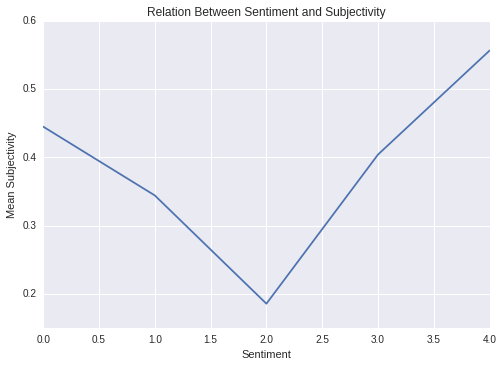

In [15]:
# extract subj/obj into its own column
data['PatternSubjObj'] = data["Phrase"].apply(lambda x: sentiment(x)[1])

sns.set_style("darkgrid")
plt.plot(data.groupby(data.Sentiment).mean().PatternSubjObj)
sns.axlabel("Sentiment", "Mean Subjectivity")
sns.plt.title("Relation Between Sentiment and Subjectivity")
plt.show()

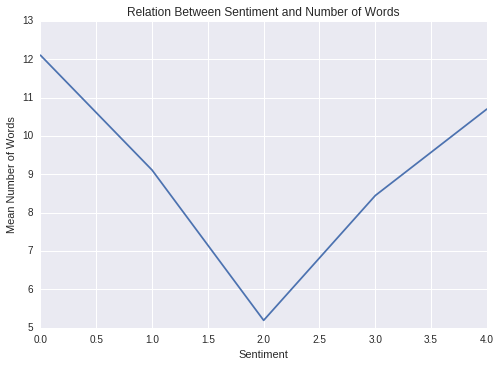

In [16]:
#extract number of words into its own column
data['NumWords'] = data["Phrase"].apply(lambda x: len(x.split(" ")))
                                        
sns.set_style("darkgrid")
plt.plot(data.groupby(data.Sentiment).mean().NumWords)
sns.axlabel("Sentiment", "Mean Number of Words")
sns.plt.title("Relation Between Sentiment and Number of Words")
plt.show()

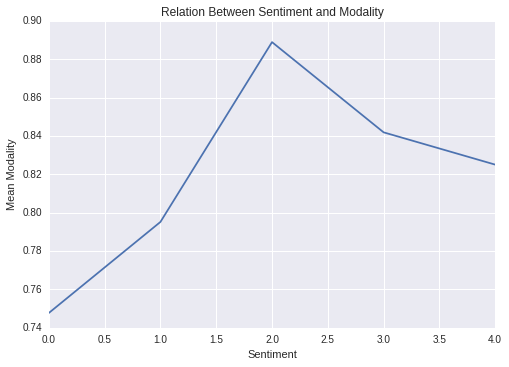

In [17]:
#extract number of words into its own column
data['Modality'] = data["Phrase"].apply(lambda x: modality(x))
                                        
sns.set_style("darkgrid")
plt.plot(data.groupby(data.Sentiment).mean().Modality)
sns.axlabel("Sentiment", "Mean Modality")
sns.plt.title("Relation Between Sentiment and Modality")

### Graph Analysis
In Sentiment vs Subjectivity, the graphs show that neutral sentences are often much more objective where the more emotional sentences, whether positive or negative, tend to be more subjective.  This makes sense intuitively - reviews that have high positive or negative sentiment would tend to be much more opinionated and therefore subjective.

It was interesting that the number of words in the phrase had nearly the same shape - the average number of words in a neutral sentence was much shorter than the more emotional phrases.  Again, this makes intuitive sense - a phrase that contains just one or two words is more likely to be a neutral combination of words that a longer, full review that contains all the intended impact.

Because the Subjectivity and the NumWords graphs had such similar shape, we wondered if these variables might be correlated.  The code below calculated the Pearson and Spearman correlations between these variables, which end up being relatively high, suggesting that they are in fact correlated.

Finally, we also used Pattern's modality function, which represents a degree of certainty.  As the Pattern documentation describes it: "The modality() function returns the degree of certainty as a value between -1.0 and +1.0, where values > +0.5 represent facts. For example, 'I wish it would stop raining' scores -0.35, whereas 'It will stop raining' scores +0.75. Accuracy is about 68% for Wikipedia texts."

Our graph of average modality for sentiment makes sense, because the neutral phrases tend to have highest modality because facts are often less emotive.  However, the entire graph is at or about +0.75, suggesting that all our phrases have fairly high modality.  Again, this makes sense intuitively because most reviewers tend to state their opinions as fact.

In [18]:
print thinkstats2.Corr(data.NumWords, data.PatternSubjObj)
print thinkstats2.SpearmanCorr(data.NumWords, data.PatternSubjObj)

0.312203203388
0.41493353356


## Most Positive and Negative Words
This section explores the words used most commonly in positive and negative reviews.  This exploration leads into our later use of tf-idf in our model.  Here, we find the most commonly used words in "very positive" and "very negative" reviews and visualize them in word clouds.

We downloaded the 1000 most common English words from [this source](https://gist.github.com/deekayen/4148741) so that our word clouds wouldn't be cluttered with phrases like "and" or "the".

In [19]:
f = open("1-1000.txt")
words1000 = f.read().splitlines()
f.close()

In [21]:
pos_words = {}
posphrases = data.Phrase[data.Sentiment==4]
for phrase in posphrases:
    words = phrase.split()
    for word in words:
        modified_word = word.lower().strip('.,;!?"()')
        if not modified_word.strip(string.ascii_letters) and modified_word != "" and modified_word not in words1000:
            if(word not in pos_words): 
                pos_words[word] = 1
            else: 
                pos_words[word] += 1
                
neg_words = {}
negphrases = data.Phrase[data.Sentiment==0]
for phrase in negphrases:
    words = phrase.split()
    for word in words:
        modified_word = word.lower().strip('.,;!?"()')
        if not modified_word.strip(string.ascii_letters) and modified_word != "" and modified_word not in words1000:
            if(word not in neg_words): 
                neg_words[word] = 1
            else: 
                neg_words[word] += 1

This code requires the wordcloud package, which you can install with `pip install wordcloud`

In [23]:
def make_word_cloud(feature_names, coefficients):
    """ Create a word cloud with the words given by feature_names
        and given coefficients. """
    cloud = wordcloud.WordCloud()
    cloud.generate_from_frequencies(zip(feature_names, coefficients))
    return cloud.to_image()

Most commone positive words


/home/anne/anaconda2/lib/python2.7/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


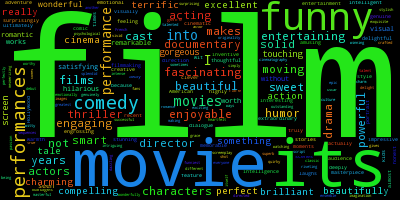

In [24]:
print "Most commone positive words"
make_word_cloud(pos_words.keys(), pos_words.values())

Most common negative words


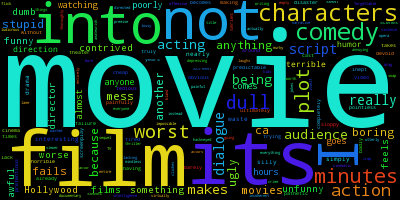

In [25]:
print "Most common negative words"
make_word_cloud(neg_words.keys(), neg_words.values())

### Wordcloud Analysis
Although the largest words in both clouds are "movie" and "film", some of the other words do give a glimpse into the sentiment.  The positive cloud has a lot of positive words like "entertaining", "funny", "enjoyable", "humor", and "moving", whereas the negative cloud contains "worst", "terrible", "not", and "dull".

# Classification Models
We decided that we would try a lot of different models based on research that we had done, learning as much as we could while seeing what would work the best.

The sections are:
- Naive Bayes Classifier
    - implemented by hand
    - using sklearn MultinomialNB
    - using NLTK
- sklearn Pipeline with a variety of estimators
- Using Logistic Regression

## Naive Bayes Classifier
### Implemented by Hand
The purpose of this section is to work through the [DataQuest Naive Bayes Tutorial](https://www.dataquest.io/blog/naive-bayes-movies/) to learn to how implement a simple version of the Naive Bayes algorithm.  The tutorial assumes the dataset has only 3 categories: 0 for neutral, 1 for positive, and -1 for negative.  It will take a bit of adaptation to make it work for the 5 categories we have.

The following two functions allow us to extract some features from each phrase in the data.  The `get_text` function takes the data and extracts all full sentences with a particular score.  It only does full sentences so that the word counts are not skewed by the constant repetitions of the phrases as they get broken down.  It returns these joined together as a single string.

Then, `count_text` takes this string and splits it into individual words.  It lowercases them and strips them of punctuation, then uses the Counter object to get a frequency count for each word.  This allows us to know how many times a certain word appears in all the reviews of a certain sentiment

In [27]:
# returns a string of all sentences with given sentiment score
def get_text(data,score):
#     given_score = data.Phrase[data.Sentiment == score]
#     return " ".join([phrase.lower() for phrase in given_score])
    phrases = data.Phrase[data.Sentiment == score]
    return " ".join(phrases)

# returns a counter object for a string of word counts
# removes punctuation and empty strings, lowercases
def count_text(text):
    words = text.split()
    actual_words = []
    for w in words:
        modified_word = w.lower().strip('.,;!?"()')
        if not modified_word.strip(string.ascii_letters) and modified_word != "":
            actual_words.append(modified_word)
    return Counter(actual_words)

The following section creates some variables to the hold the texts and wordcount dictionaries for each of the possible sentiment scores

In [28]:
very_negative_text = get_text(data, 0)
negative_text = get_text(data, 1)
neutral_text = get_text(data, 2)
positive_text = get_text(data, 3)
very_positive_text = get_text(data, 4)

# Generate word counts for each tone.
very_negative_wordcounts = count_text(very_negative_text)
negative_wordcounts = count_text(negative_text)
neutral_wordcounts = count_text(neutral_text)
positive_wordcounts = count_text(positive_text)
very_positive_wordcounts = count_text(very_positive_text)

print "Negative text sample:", very_negative_text[:300]

Negative text sample: would have a hard time sitting through this one have a hard time sitting through this one Aggressive self-glorification and a manipulative whitewash self-glorification and a manipulative whitewash Trouble Every Day is a plodding mess . is a plodding mess plodding mess could hate it for the same reas


In [29]:
def get_count_for_score(score, data):
    return len(data.Phrase[data.Sentiment == score])

# We need these counts to use for smoothing when computing the prediction.
very_negative_count = get_count_for_score(0,data)
negative_count = get_count_for_score(1, data)
neutral_count = get_count_for_score(2, data)
positive_count = get_count_for_score(3, data)
very_positive_count = get_count_for_score(4, data)

num = float(len(data))
# These are the class probabilities (we saw them in the formula as P(y)).
prob_very_negative = very_negative_count / num
prob_negative = negative_count / num
prob_neutral = neutral_count / num
prob_positive = positive_count / num
prob_very_positive = very_positive_count / num

def make_class_prediction(text, wordcounts, class_prob, class_count):
    prediction = 1
    text_counts = count_text(text)
    for word in text_counts:
        # For every word in the text, we get the number of times that word occured in the reviews for a given class, 
        # add 1 to smooth the value, and divide by the total number of words in the class 
        # (plus the class_count to also smooth the denominator).
        # Smoothing ensures that we don't multiply the prediction by 0 if the word didn't exist in the training data.
        # We also smooth the denominator counts to keep things even.        
        prediction *=  text_counts.get(word) * ((wordcounts.get(word, 0) + 1) / float(sum(wordcounts.values()) + class_count))
    # Now we multiply by the probability of the class existing in the documents.
    return prediction * class_prob

# As you can see, we can now generate probabilities for which class a given review is part of.
# The probabilities themselves aren't very useful -- we make our classification decision based on which value is greater.
print "Review:", data.Phrase[0], data.Sentiment[0]
print "Very Negative prediction:", make_class_prediction(data.Phrase[0], very_negative_wordcounts, prob_very_negative, very_negative_count)
print "Negative prediction:", make_class_prediction(data.Phrase[0], negative_wordcounts, prob_negative, negative_count)
print "Neutral prediction:", make_class_prediction(data.Phrase[0], neutral_wordcounts, prob_neutral, neutral_count)
print "Positive prediction:", make_class_prediction(data.Phrase[0], positive_wordcounts, prob_positive, positive_count)
print "Very Positive prediction:", make_class_prediction(data.Phrase[0], very_positive_wordcounts, prob_very_positive, very_positive_count)

Review: A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . 1
Very Negative prediction: 3.67811909387e-78
Negative prediction: 2.0250170009e-77
Neutral prediction: 1.67847551086e-77
Positive prediction: 4.50313251885e-79
Very Positive prediction: 4.7036828234e-79


In [30]:
def make_decision(text):
    # Compute the negative and positive probabilities.
    predictions = [
        make_class_prediction(text, very_negative_wordcounts, prob_very_negative, very_negative_count),
        make_class_prediction(text, negative_wordcounts, prob_negative, negative_count),
        make_class_prediction(text, neutral_wordcounts, prob_neutral, neutral_count),
        make_class_prediction(text, positive_wordcounts, prob_positive, positive_count),
        make_class_prediction(text, very_positive_wordcounts, prob_very_positive, very_positive_count) ]
    return predictions.index(max(predictions))

make_decision(data.Phrase[0])

1

In [31]:
predictions = []
for phrase in testdata.Phrase:
    predictions.append(make_decision(phrase))

In [32]:
# Create a submission
make_submission(predictions, "naivebayes_2.csv")

The first submssion scored scored **0.42851** on Kaggle, which is pretty disappointing because it's worse than the "Everything Neutral benchmark" at 0.51 - what you would score if you just guess everything as neutral.

However, we then went back and changed the code to account for ALL phrases when calculating word frequency (instead of just words in the full sentences), the model improved significantly!  We got **0.53901**, which is better than the Neutral Benchmark!

### Using sklearn Builtin Algorithms for Naive Bayes


In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Generate counts from text using a vectorizer.  There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer(stop_words='english')
train_features = vectorizer.fit_transform([r for r in data.Phrase])
test_features = vectorizer.transform([r for r in testdata.Phrase])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, and the existing classifications in the training set.
nb = MultinomialNB()
nb.fit(train_features, [int(r) for r in data.Sentiment])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

make_submission(predictions, "sklearn_bayes_1.csv")

So after all that work making our by-hand naive bayes classifier, I followed the tutorial on how to use sk-learn to implement it.  The by-hand code takes 5-10 minutes to run and gave us .53, this one finished in 20 seconds and gave us a kaggle score of **0.59267**.  Wow, that's a big improvement.  But it was definitely nice to go through and see how the algorithm actually works behind the scenes, because it made a lot of sense separated out like that

### NLTK Builtin Naive Bayes
The previous code was all based on the DataQuest tutorial.  Now, we found a [different tutorial](http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/) that works with the builtin Naive Bayes classifier in NLTK instead.  Again, since it's working with the NLTK movie corpus instead of our data, there will have to be adjustments to make it fit in five categories instead of two.

In [37]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import string
 
# bag of words feature extraction
def word_feats(phrase):
    actual_words = []
    words = phrase.split()
    d = {}
    for w in words:
        modified_word = w.lower().strip('.,;!?"()')
        if not modified_word.strip(string.ascii_letters) and modified_word != "":
            if w not in d:
                d[w] = 1
            else:
                d[w] +=1
    return d

very_neg = data.Phrase[data.Sentiment == 0]
neg = data.Phrase[data.Sentiment == 1]
neutral = data.Phrase[data.Sentiment == 2]
pos = data.Phrase[data.Sentiment == 3]
very_pos = data.Phrase[data.Sentiment == 4]

very_neg_feats = [(word_feats(phrase),0) for phrase in very_neg]
neg_feats = [(word_feats(phrase),1) for phrase in neg]
neutral_feats = [(word_feats(phrase),2) for phrase in neutral]
pos_feats = [(word_feats(phrase),3) for phrase in pos]
very_pos_feats = [(word_feats(phrase),4) for phrase in very_pos]

verynegcutoff = len(very_neg_feats)*3/4
negcutoff = len(neg_feats)*3/4
neutralcutoff = len(neutral_feats)*3/4
poscutoff = len(pos_feats)*3/4
veryposcutoff = len(very_pos_feats)*3/4

trainfeats = very_neg_feats[:verynegcutoff] + \
            neg_feats[:negcutoff] + \
            neutral_feats[:neutralcutoff] + \
            pos_feats[:poscutoff] + \
            very_pos_feats[:veryposcutoff]
                
testfeats = very_neg_feats[verynegcutoff:] + \
            neg_feats[negcutoff:] + \
            neutral_feats[neutralcutoff:] + \
            pos_feats[poscutoff:] + \
            very_pos_feats[veryposcutoff:]
print 'train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print 'accuracy:', nltk.classify.util.accuracy(classifier, testfeats)
classifier.show_most_informative_features()

train on 117043 instances, test on 39017 instances
accuracy: 0.335520414178
Most Informative Features
                dazzling = 1                   4 : 2      =    216.1 : 1.0
              unpleasant = 1                   0 : 2      =    198.8 : 1.0
                    crap = 1                   0 : 2      =    183.8 : 1.0
                  poorly = 1                   0 : 2      =    168.8 : 1.0
                  insult = 1                   0 : 2      =    161.3 : 1.0
             achievement = 1                   4 : 2      =    158.5 : 1.0
           unimaginative = 1                   0 : 2      =    153.8 : 1.0
               masterful = 1                   4 : 2      =    140.0 : 1.0
                     bad = 1                   0 : 4      =    135.6 : 1.0
               painfully = 1                   0 : 3      =    128.8 : 1.0


In [38]:
right = 0
for d,res in testfeats:
    if res == classifier.classify(d):
        right+=1
print right / float(len(testfeats))

0.335520414178


It's not terribly accurate, but we might as well make a model with all the training data, and submit the test data to Kaggle and see what happens.

In [39]:
classifier_alltrain = NaiveBayesClassifier.train(very_neg_feats + neg_feats + neutral_feats + pos_feats + very_pos_feats)

pred= []
for phrase in testdata.Phrase:
    pred.append(classifier_alltrain.classify(word_feats(phrase)))
    
make_submission(pred, "nltk_bayes_1.csv")

Not unexpectedly, we didn't do great submitting this to Kaggle: **0.38863**.  The sklearn model did significantly better

## Trying sklearn Pipeline
We found out about sklearn's Pipeline feature, which allows you to string together ways to extract features and estimate your model, and decided we wanted to try different pipelines and add features and see where it could take us.

In [42]:
# create a pipeline of transforms and an estimator
def scikit_learn(train_set, train_labels):
    pipeline1 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsOneClassifier(LinearSVC())),
         ])
    
    pipeline2 = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier()),
        ])
    
    pipeline3 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsRestClassifier(LinearSVC())),
         ])
    
    pipeline4 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', MultinomialNB()),
         ])
    
    pipeline5 = Pipeline([('vect', CountVectorizer()),
         ('clf', MultinomialNB()),
         ])
    
    pipeline6 = Pipeline([('vect', CountVectorizer()),
         ('clf', OneVsOneClassifier(LinearSVC())),
         ])
    
    pipeline7 = Pipeline([('vect', CountVectorizer()),
         ('clf', OneVsRestClassifier(LinearSVC())),
         ])
    
    pipeline8 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsOneClassifier(LogisticRegression())),
         ])
    
    # don't run pipeline 9
    # for some reason it takes a long time to run
    pipeline9 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsOneClassifier(SVC(C=1, kernel='linear'))),
         ])

    X_train = np.asarray(train_set)
    text_clf = pipeline8.fit(X_train, np.asarray(train_labels))
    return text_clf

# make prediction
alg = scikit_learn(data.Phrase, data.Sentiment)
predicted = alg.predict(testdata.Phrase)
make_submission(predicted, "pipeline_8.csv")

`pipeline1`, which came from [this github source](https://github.com/yogesh-kamble/kaggle-submission/blob/master/movie_review.py) scored **0.62935** on Kaggle

`pipeline2`, which came from [this sample sklearn code](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) scored **0.55996**

`pipeline3` came from some research on OneVsOneClassifier and finding out there is also a OneVsRestClassifier, and testing that out.  It scored **0.61964**

`pipeline4` came from the previous code working with the DataQuest tutorial and the sklearn builtins for Naive Bayes.  We wanted to see how it might perform in the pipeline with additional transforms like tf-idf.  It scored **0.58289**, which is worse than the Naive Bayes dataquest code.

`pipeline5` is the same steps we took in the sklearn Naive Bayes from DataQuest (no tf-idf) because I wondered it would be the same, and if Pipeline was just doing the same steps that we had done by hand above.  It scored **0.59882**.  This is super interesting because the DataQuest code scored 0.592, and also just used CountVectorizer and MultinomialNB.  I wonder what Pipeline does that's different and gave it the extra score?

`pipeline6` is the same as `pipeline1` without the tf-idf transform.  If removing that step made the MultinomialNB pipeline better, maybe it will also improve this one.  It scored **0.61839**, which is interesting because it's slightly less than `pipeline1`'s score - clearly the tf-idf step helps when doing OneVsOne and LinearSVC, but hurts when doing MultinomialNB.  Why?

`pipeline7` is analogous to `pipeline6` - it tests the removal of the tf-idf step for the OneVsRestClassifier.  It scored **0.60384**.  Again, slightly less than when it included tf-idf.

`pipeline8` is because we wanted to try something other than LinearSVC in our classifier to see how that would affect it.  We tried LogisiticRegression and it scored **0.61241** - slightly worse than LinearSVC.

`pipeline9` uses a kernel=linear SVC instead of LinearSVC.  According to sklearn docs for LinearSVC: "Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples."  We don't know how it scored because it took too long to run.

## Using Logistic Regression to train a model.
Inspiration was pulled from [this NLP article](https://jessesw.com/NLP-Movie-Reviews/). Logistic Regression is a scikit learn model, documentation for scikit learn can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

First, clean the data by sending the word to lowercase, remoing all punctuation marks, and spliting the words at every space. 

In [43]:
def cleanData(text):
    punctuation = {".", "/", "\\", ","}
    frequencyTracker = {}; 
    for mark in punctuation: 
        text = text.lower().replace(mark, " ")
    return text.lower().split()

In [54]:
#acqure all of the 'true' data, place all the data known to be true into array y_train
y_training = data['Sentiment']

In [55]:
#calls the clean data function for both the training and test data. 
# Then appends the cleaned data to array train and test data, respectively.
training = []
for word in data['Phrase']: 
    training.append(" ".join(cleanData(word)))
testing = []
for otherword in testdata['Phrase']: 
    testing.append(" ".join(cleanData(otherword)))

Next we will use sklearn's TFIV library to vectorize the data and explore how often and how important a certain word occurs and is in the data set. This vectorization function that will later help determine which words are in positive reviews and which words are in negative reviews. [Here is the documentation for the TFIV sklearn class](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

As you can see from the documentation, the parameters involved are: 
- "min-df": this ignores the frequency of words less than a specific threshold value. 
- "max_features": If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
- "strip accents": removes any ascii or unicode characters that are not words. 
- "analyzer": could be either words or characters to analyze
- "token pattern": Regex denoting what constitutes a token or whateever as defined by analyzer"
- "ngram_range": the lower and upper boundary for n gram parsing. An n gram is essentially spliting up the sentence into length n and making a model with these different data sets. iNstead of analyzing and training on each word or entire sentence it can be broken down into n grams. [More info here](http://www.text-analytics101.com/2014/11/what-are-n-grams.html)
- "use_idf": this allows the inverse document frequency to reweight itself. default is set to true. 
- "smooth_idf": increases the document count for each word so that each word is at least in one document. This prevents dividing by 0. 
- "sublinear_tf": sublinear scaling. Instead of log, use 1 + log(tf)
- "stop_words": words that were ignored because of their low frequency count, exceeded maximum counts, or occured in too few documents.

In [56]:
tfv = TFIV(min_df=3,  max_features=None, 
        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
        stop_words = 'english')

Then we will combine the train data and the test data in order to vectorize the data. After the tfv fits the data, then it transforms the documents into a document-terms matrix. Then seperates the data back into training set and testing set in order to continue with the process. The tfv transform returns a sparse matrix.
Finally, then we are ready and able to use Logistic Regression on the vectorized document-term matrix.

In [58]:
X_all = training + testing # Combine both to fit the TFIDF vectorization.
lentrain = len(training)

tfv.fit(X_all) 
X_all = tfv.transform(X_all)

X_training = X_all[:lentrain] # Separate back into training and test sets. 
X_testing = X_all[lentrain:]

In [59]:
print X_training.shape
print y_training.shape

(156060, 89472)
(156060,)


We can see above that the shape of X_training, the sparse matrix, has more rows than columns.

We can see above that y_training is a 1D array of sentiment values.

Parameters from scikit learn's Logistic Regression: 
"C": This is an optional float where the value is the inverse of the regularization strength. What is regularization strength you ask? Well here is what the internet says regularization strength is: 
    Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. When you train a model such as a logistic regression model, you are choosing parameters that give you the best fit to the data. This means minimizing the error between what the model predicts for your dependent variable given your data compared to what your dependent variable actually is.
    The problem comes when you have a lot of parameters (a lot of independent variables) but not too much data. In this case, the model will often tailor the parameter values to idiosyncrasies in your data -- which means it fits your data almost perfectly. However because those idiosyncrasies don't appear in future data you see, your model predicts poorly.
    
"dual": This is a boolean where it's false if the number of samples > number of features and true for the opposite. 
In our case, this should be set to false because samples > features 

"penalty": Either choice of L1 or L2. Apparently the L1 norm is not differentiable, therefore the L2 norm will leave the data looking smoother. 

"random-state": when shuffling the data, this value will be the seed if trying to recreate it. 

In [60]:
grid_values = {'C':[30]} # this number is chosen for the reasoning above. More Cs!

log_reg = LogisticRegression(penalty = 'l2', dual = True, random_state = 0)

#Grid Search is an approximator for values that cannot be learned, but rather searches the space for the best fit. 
model_LR = GridSearchCV(log_reg, grid_values) 
#fit the model 
model_LR.fit(X_training, y_training) # Fit the model.

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [61]:
#mean scores, std, and params for all parameter combination of estimator functions
model_LR.grid_scores_

[mean: 0.53681, std: 0.00802, params: {'C': 30}]

In [62]:
#this is what the model predicts is the best estimator, this is like a line of best fit. 
#This is the estimator that gave the highest score in exhange for the smallest loss.
model_LR.best_estimator_

LogisticRegression(C=30, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Once we have a model, now we can predict the results of the test, put the results in a csv, and submit to kaggle.

In [63]:
#use the model to precist the scores of the test data
#convert results to csv

LR_result = model_LR.predict(X_test) # We only need the probabilities that the movie review was a 7 or greater. 

make_submission(LR_result, "Logistic_Reg.csv")

After uploading to kaggle, we discovered that the score was **0.58660**. This is interestingly low, but also close to our approximated, estimated mean. This was just an estimator model using linear regression on this estimation. We could have perhaps scored higher if we would have explored more with the scoring = 'roc_auc' attribute that belongs to GridSearchCV. This would just taken the area underneath the curve and perhaps provided a better approximation. 

# Neural Networks with Lasagne
This section describes our work with implementing a neural network in using the  [Lasagne](https://github.com/Lasagne/Lasagne) package.  Our code for this is heavily based off the [Lasagne MNIST tutorial](http://lasagne.readthedocs.org/en/latest/user/tutorial.html) and we used their method of implementing a Multi-Layer Perceptron model and training it on our particular dataset.

## Word2Vec
We loaded data into our network using word2vec encodings of our original phrase data.  The word2vec algorithm by Google used billions of Google news data sources to train a model that basically provides a lookup table for an enormous vocabulary.  The idea is that for the words, it would be able to provide a 300-dimensional vector of features that represents the various semantic properties of a word.  This vector could then be used to predict similar words or words that are likely to succeed other words.

In using word2vec in our encodings, we are able to use it as a lookup table.  Our training data has the shape (68030, 300) because we have 68030 phrases.  For each phrase, word2vec was used on each word to generate a 300-dimensional vector of features for the word.  Then, the vectors for all words in a phrase were averaged together to yield a single 1x300 vector for a phrase that represented the average semantic encoding of the phrase.  This was done for all 68030 phrases to give us the final dense matrix of 68030 rows and 300 columns.

In [3]:
def load_dataset():

    # load the training data using pickle
    # the data X has shape (68030, 300) and is the average word2vec semantic encodings for each phrase
    # the data y has shape (68030,) and is the sentiment for each phrase from 0-4
    f = open('rotten_tomatoes_train.pickle')
    X = pickle.load(f)
    y = pickle.load(f)
    f.close()
    
    def make_splits(X,y):
        splits = LabelShuffleSplit(data.SentenceId, test_size=0.5, n_iter=1)
        for train_indices, test_indices in splits:
            X_train = X[train_indices,:]
            y_train = y[train_indices]
            X_test = X[test_indices, :]
            y_test = y[test_indices]
            return X_train, X_test, y_train, y_test

    # make train_test_split on the sentenceID
    X_train, X_test, y_train, y_test = make_splits(X,y)
    
    # we used sklearn's train_test_split to separate 50% of our data as test data
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)

    # We reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # we return all the arrays (in np.asarray format, so that it is compatible with theano)
    return np.asarray(X_train), np.asarray(y_train), np.asarray(X_val), np.asarray(y_val), np.asarray(X_test), np.asarray(y_test)

## The MLP
The following function builds a Multi-Layer Perceptron model for our neural network.  Based on our research, an MLP as we understand it is a way to expand upon Logistic Regression by adding one or more hidden layers.  The input layer maps to the hidden layer through a set of weights that are learned, and then it maps from the final hidden layer to a set of outputs through another set of learned weights.

Our MLP has two hidden layers of 800 units each.  It applies 50% dropout following each hidden layer and 20% dropout to the initial input.  It ends up with a softmax output layer with 5 units, for the 5 classes of sentiment in our data.  The [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is a form of normalized logistic regression (that is necessary in neural networks) but that is commonly used in multiclass classification such as this problem.  The specifications of the network and each layer are based on the Lasagne tutorial.

A representation of the layers of our MLP network is:

Input | 20% dropout | Hidden layer 1 | 50% dropout | Hidden layer 2 | 50% dropout | Output layer (5)

In [4]:
def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 5 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 300),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 5 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid2_drop, num_units=5,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out


## Minibatch Iterator
This section (again, using code from teh Lasagne tutorial) creates a helper function that, using yield, returns an iterable generator object that allows us to create batches from our full input data (either randomized or sequential depending on the shuffle variable).  This function gets used in the training of our model and the train function that we define is performed on each minibatch, and the loss for each epoch is the sum of the loss for each batch within the epoch.

In [ ]:
# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == len(targets)
    print (inputs.shape[0])
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Main Training
The training of the model uses 500 epochs and trains in minibatches on each epoch.

Before training, we create the loss and update functions.  The update function uses Stochastic Gradient Descent.  The error for each phrase and sentiment value can be calculated, and then we need the gradient of the error, and we want to sum all these gradients for all data points.  This is computationally expensive so instead it chooses a random x,y pair (in our case, a phrase and corresponding sentiment value) to calculate the gradient and moves along the curve relative to the error of the previous point so that it can move more finely when necessary.  Lasagne implements this algorithm for us.

The loss function uses [categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression), which calculates a measure of similarity between the prediction for a given data point and its actual value.  This is one of many loss functions that Lasagne provides, and we chose to use it based on the tutorial example.

In [ ]:
# define number of epochs to train for
num_epochs=500

# Load the dataset
print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_val = y_val.astype(np.int32)

# Prepare Theano variables for inputs and targets
# input_var is a matrix because it will be 2-dimensional (68030,300)
# and target_var is a vector because it will be 1-dimensional (68030,)
input_var = T.matrix('inputs')
target_var = T.ivector('targets')

# Create neural network model
print("Building model and compiling functions...")
network = build_mlp(input_var)

# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)

test_loss = test_loss.mean()

# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

# this function will be used to predict on our actual test data to make a Kaggle submission
pred_fn = theano.function([input_var], test_prediction)

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        inputs, targets = batch
        a = train_fn(inputs, targets) #a is the loss returned by train_fn
        train_err += a
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

# dump the network weights to a file like this:
np.savez('model3.npz', *lasagne.layers.get_all_param_values(network))


## Make Predictions
This code uses the trained network to make predictions and create a Kaggle submission file

In [16]:
# make predictions and submission

# Prepare Theano variables for inputs and targets
input_var = T.matrix('inputs')
target_var = T.ivector('targets')

network = build_mlp(input_var)

# load the model
with np.load('model2.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

test_prediction = lasagne.layers.get_output(network, deterministic=True)

pred_fn = theano.function([input_var], test_prediction)

# load the test data
f = open('X_test_word2vec.pickle')
X_testdata = pickle.load(f)
f.close()

# make predictions!
pred_probabilities = pred_fn(X_testdata)

predictions = list(map(lambda pr: list(pr).index(max(pr)), pred_probabilities))

make_submission(predictions, "neural2.csv")